# Data Preprocessing

Tasks
1.   Load Kaggle traffic sign data from drive
2.   Unpickle files
3.   Filter out classes not related to speed
4.   Normalize number of samples per class
5.   Split into train / val / test sets
6.   Shuffle datasets
7.   Resize
8.   Normalize pixel values
9.   Make pytorch dataloaders

In [1]:
import pickle
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Data directory
# Change this as needed
data_dir = '/content/gdrive/My Drive/APS360 Project/'

In [5]:
# Data loaders

def get_data_loader(batch_size):
    ''' The Kaggle dataset is split into three pickle files: train.pickle,
    valid.pickle, and test.pickle.
    The function will combine the three datasets and resplit them such that the
    resulting split is approximately 70% training, 15% validation, and 15% testing.
    The function filters classes 0-8,13,14,32 only, as they are related to speed.
    The splitting ratio will be applied to each class, to avoid imbalance of 
    classes in the training/validation/testing samples.'''

    classes = ('Speed limit (20km/h)',
            'Speed limit (30km/h)',
            'Speed limit (50km/h)',
            'Speed limit (60km/h)',
            'Speed limit (70km/h)',
            'Speed limit (80km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)',
            'Yield',
            'Stop',
            'End of all speed and passing limits')
    # Index of chosen classes in the original dataset
    # In our reconstructed dataset, the same classes will have indexes 0-11
    original_labels = (0,1,2,3,4,5,6,7,8,13,14,32)
    # load pickle files
    # will combine datasets from three seperate pikcle files
    
    with open(data_dir+'train.pickle', 'rb') as file:
        data1 = pickle.load(file)

    with open(data_dir+'valid.pickle', 'rb') as file:
        data2 = pickle.load(file)

    with open (data_dir+'test.pickle', 'rb') as file:
        data3 = pickle.load(file)

    images = np.concatenate((data1['features'], data2['features'], data3['features']))
    labels = np.concatenate((data1['labels'], data2['labels'], data3['labels']))

    # shuffle
    np.random.seed(9001)
    indices = list(range(images.shape[0]))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # split into train /  valid / test
    train_split = 0.7
    valid_split = 0.85

    train_images = images[0:int(train_split*images.shape[0])]
    train_labels = labels[0:int(train_split*images.shape[0])]

    valid_images = images[int(train_split*images.shape[0]):int(valid_split*images.shape[0])]
    valid_labels = labels[int(train_split*images.shape[0]):int(valid_split*images.shape[0])]

    test_images = images[int(valid_split*images.shape[0]):]
    test_labels = labels[int(valid_split*images.shape[0]):]

   # sort into classes
    class_train_images = []
    class_train_labels = []
    for i in range(len(classes)):
        class_train_indices = np.where(train_labels==original_labels[i])[0]
        class_train_images.append(train_images[class_train_indices])
        
        # Don't want the original labels
        # This is where we convert to our own labels: 0-11
        class_train_labels.append(np.full(len(class_train_indices),i)) 

    class_valid_images = []
    class_valid_labels = []
    for i in range(len(classes)):
        class_valid_indices = np.where(valid_labels==original_labels[i])[0]
        class_valid_images.append(valid_images[class_valid_indices])
        
        # Don't want the original labels
        # This is where we convert to our own labels: 0-11
        class_valid_labels.append(np.full(len(class_valid_indices),i)) 

    class_test_images = []
    class_test_labels = []
    for i in range(len(classes)):
        class_test_indices = np.where(test_labels==original_labels[i])[0]
        class_test_images.append(test_images[class_test_indices])

        # Don't want the original labels
        # This is where we convert to our own labels: 0-11
        class_test_labels.append(np.full(len(class_test_indices),i)) 

    # normalize number of samples in each class
    
    # train
    desired_size=int(600*0.7)
    extra_train_images = []
    extra_train_labels = []
    for i in range(len(classes)):
        # Randomly sample from the original class images to duplicate to extra
        if class_train_images[i].shape[0] < desired_size:
            extra_train_images.append(
                class_train_images[i][np.random.randint(
                    low=0,
                    high=class_train_images[i].shape[0],
                    size=desired_size-class_train_images[i].shape[0])])

            # Add random noise to create variation from originals
            noise_intensity = 0.1

            extra_train_images[i] = (1-noise_intensity)*extra_train_images[i]+noise_intensity*(255*torch.rand(*extra_train_images[i].shape).detach().numpy())
            extra_train_images[i] = np.clip(extra_train_images[i], 0, 255)

            # add labels for extra samples
            extra_train_labels.append(np.full(extra_train_images[i].shape[0], i))

            # append to original
            class_train_images[i] = np.concatenate((class_train_images[i],extra_train_images[i]))
            class_train_labels[i] = np.concatenate((class_train_labels[i],extra_train_labels[i]))
        else:
            # if more than desired_size images, truncate
            extra_train_images.append([])
            extra_train_labels.append([])
            class_train_images[i] = class_train_images[i][:desired_size]
            class_train_labels[i] = class_train_labels[i][:desired_size]
    # valid
    desired_size=int(600*0.15)
    extra_valid_images = []
    extra_valid_labels = []
    for i in range(len(classes)):
        # Randomly sample from the original class images to duplicate to extra
        if class_valid_images[i].shape[0] < desired_size:
            extra_valid_images.append(
                class_valid_images[i][np.random.randint(
                    low=0,
                    high=class_valid_images[i].shape[0],
                    size=desired_size-class_valid_images[i].shape[0])])


            # add labels for extra samples
            extra_valid_labels.append(np.full(extra_valid_images[i].shape[0], i))

            # append to original
            class_valid_images[i] = np.concatenate((class_valid_images[i],extra_valid_images[i]))
            class_valid_labels[i] = np.concatenate((class_valid_labels[i],extra_valid_labels[i]))
        else:
            # if more than desired_size images, truncate
            extra_valid_images.append([])
            extra_valid_labels.append([])
            class_valid_images[i] = class_valid_images[i][:desired_size]
            class_valid_labels[i] = class_valid_labels[i][:desired_size]

    # test
    desired_size=int(600*0.15)
    extra_test_images = []
    extra_test_labels = []
    for i in range(len(classes)):
        # Randomly sample from the original class images to duplicate to extra
        if class_test_images[i].shape[0] < desired_size:
            extra_test_images.append(
                class_test_images[i][np.random.randint(
                    low=0,
                    high=class_test_images[i].shape[0],
                    size=desired_size-class_test_images[i].shape[0])])
            # Add random noise to create variation from originals
            noise_intensity = 0.3

            extra_test_images[i] = extra_test_images[i]+noise_intensity*(-255*np.ones(extra_test_images[i].shape)+2*255*torch.rand(*extra_test_images[i].shape).detach().numpy())
            extra_test_images[i] = np.clip(extra_test_images[i], 0, 255)

            # Add random noise to create variation from originals
            noise_intensity = 0.05

            extra_test_images[i] = (1-noise_intensity)*extra_test_images[i]+noise_intensity*(255*torch.rand(*extra_test_images[i].shape).detach().numpy())
            extra_test_images[i] = np.clip(extra_test_images[i], 0, 255)
            # add labels for extra samples
            extra_test_labels.append(np.full(extra_test_images[i].shape[0], i))

            # append to original
            class_test_images[i] = np.concatenate((class_test_images[i],extra_test_images[i]))
            class_test_labels[i] = np.concatenate((class_test_labels[i],extra_test_labels[i]))
        else:
            # if more than desired_size images, truncate
            extra_test_images.append([])
            extra_test_labels.append([])
            class_test_images[i] = class_test_images[i][:desired_size]
            class_test_labels[i] = class_test_labels[i][:desired_size]

    # combine class arrays
    train_images = np.concatenate(class_train_images)
    train_labels = np.concatenate(class_train_labels)

    valid_images = np.concatenate(class_valid_images)
    valid_labels = np.concatenate(class_valid_labels)

    test_images = np.concatenate(class_test_images)
    test_labels = np.concatenate(class_test_labels)

    # shuffle again
    indices = list(range(train_images.shape[0]))
    np.random.shuffle(indices)
    train_images = train_images[indices]
    train_labels = train_labels[indices]
    
    indices = list(range(valid_images.shape[0]))
    np.random.shuffle(indices)
    valid_images = valid_images[indices]
    valid_labels = valid_labels[indices]
   
    indices = list(range(test_images.shape[0]))
    np.random.shuffle(indices)
    test_images = test_images[indices]
    test_labels = test_labels[indices]

    # SHADMAN'S CHANGES ABOVE THIS

    # make into torch datasets
    train_image_tensor = torch.Tensor(train_images.transpose(0,3,1,2))
    train_label_tensor = torch.Tensor(train_labels)
    
    val_image_tensor = torch.Tensor(valid_images.transpose(0,3,1,2))
    val_label_tensor = torch.Tensor(valid_labels)
    
    test_image_tensor = torch.Tensor(test_images.transpose(0,3,1,2))
    test_label_tensor = torch.Tensor(test_labels)
   
    trainset = TensorDataset(train_image_tensor, train_label_tensor)
    valset = TensorDataset(val_image_tensor, val_label_tensor)
    testset = TensorDataset(test_image_tensor, test_label_tensor)

    # resize and normalization
    transform = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset.transform = transform
    valset.transform = transform
    testset.transform = transform

    # make data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        num_workers=1)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        num_workers=1)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        num_workers=1)
    
    return train_loader, val_loader, test_loader, classes 

In [6]:
batch_size = 32
train_loader, val_loader, test_loader, classes = get_data_loader (batch_size)
print (classes)
print (len(train_loader))
print (len(val_loader))
print (len(test_loader))

('Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'Yield', 'Stop', 'End of all speed and passing limits')
158
34
34


In [7]:
# Check one batch
dataiter = iter(train_loader)


[[[110 123 134 ...  75  86  89]
  [ 92 105 106 ...  95  94  79]
  [ 79  86  85 ... 104  96  73]
  ...
  [ 67  61  60 ...  45  44  44]
  [ 72  70  66 ...  48  47  48]
  [ 73  68  67 ...  51  52  52]]

 [[ 89 100 103 ...  66  76  69]
  [ 79  89  89 ...  80  73  61]
  [ 68  73  73 ...  86  69  56]
  ...
  [ 52  46  45 ...  31  31  30]
  [ 56  54  52 ...  32  32  33]
  [ 58  55  55 ...  36  36  36]]

 [[ 99 109 107 ...  70  84  77]
  [ 92 104 101 ...  79  76  65]
  [ 79  85  86 ...  84  73  62]
  ...
  [ 52  46  48 ...  34  34  32]
  [ 57  53  52 ...  34  34  35]
  [ 58  53  56 ...  36  36  37]]]
[[[ 47  50  50 ...  54  59  58]
  [ 42  45  48 ...  53  54  52]
  [ 52  50  47 ...  52  54  55]
  ...
  [ 77  85  92 ... 186 197 202]
  [ 89  92 107 ... 180 194 213]
  [101  99 111 ... 179 201 216]]

 [[ 42  46  44 ...  49  54  52]
  [ 37  41  43 ...  44  46  45]
  [ 45  43  42 ...  47  49  50]
  ...
  [ 72  76  82 ... 182 195 205]
  [ 83  85 102 ... 174 195 214]
  [ 99  94 101 ... 172 199 215]]



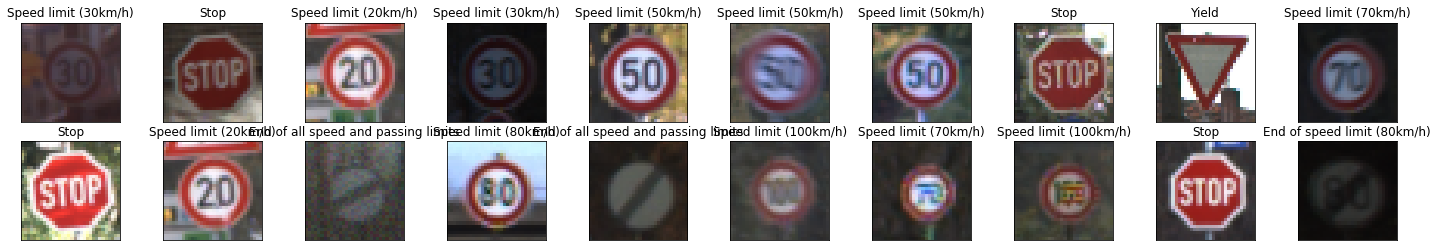

In [8]:
images, labels = dataiter.next()
images = images.numpy().astype(int) # convert images to numpy for display
labels = labels.int()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])
    print(images[idx])

In [9]:
print (images[7])

[[[ 43  80  72 ... 255 255 255]
  [ 43  69  60 ... 255 255 255]
  [ 48  88  83 ... 255 255 255]
  ...
  [ 46  39  38 ...  89  72  60]
  [ 54  49  46 ...  54  60  58]
  [ 45  42  38 ...  54  56  61]]

 [[ 45  78  71 ... 255 255 255]
  [ 43  56  56 ... 255 255 255]
  [ 48  85  80 ... 255 255 255]
  ...
  [ 42  42  39 ...  91  71  58]
  [ 48  49  45 ...  64  62  55]
  [ 37  39  37 ...  61  58  56]]

 [[ 42  74  65 ... 243 255 255]
  [ 42  49  45 ... 255 255 255]
  [ 49  77  62 ... 255 255 255]
  ...
  [ 38  43  40 ...  83  51  50]
  [ 49  51  46 ...  52  54  54]
  [ 35  41  39 ...  54  50  55]]]


In [ ]:
# close all figures to prevent memory leak
plt.close('all')

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)//(max_val - min_val)             #this is kinda brilliant
    return norm_labels




#TRAIN

Tasks:
 - Calculate training accuracy
 - Calculate training loss
 - Calculate validation accuracy
 - Calculate validation loss
 - Store weights in epoch files (we may have to be smart about WHERE we're saving this so that we don't clutter up the drive)
 - Get accuracy of model after training is complete
 - Plot everything


In [ ]:
def train(model, train_loader, val_loader, batch_size=27, num_epochs=21, learning_rate = 0.001):

    torch.manual_seed(1000)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_acc, val_acc, train_loss, val_loss = [], [], [], []

    # training
    print ("Training Started...\n")
    if torch.cuda.is_available():
        print("U S I N G   C U D A \n\n")

    for epoch in range(num_epochs):                                     # the number of iterations
        sum_train_loss = 0.0
        sum_val_loss = 0.0

        n = 0                                                           # Number of training iterations in this epoch
        m = 0                                                           # Number of validation iterations in this epoch

        for imgs, labels in iter(train_loader):
                
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            out = model(imgs)                                           # forward pass
            loss = criterion(out, labels.long())                               # compute the total loss
            loss.backward()                                             # backward pass (compute parameter updates)
            optimizer.step()                                            # make the updates for each parameter
            optimizer.zero_grad()                                       # a clean up step for PyTorch
            sum_train_loss += loss.item() 
            n += 1
        
        for imgs, labels in iter(val_loader):
            
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()                                    # cudafication for speeeeed

            out = model(imgs)                                            
            loss = criterion(out, labels.long())                               # compute loss with Cross Entropy
            sum_val_loss += loss.item()
            m += 1

        # track accuracy and loss
        train_acc.append(get_accuracy(model, train_loader))
        val_acc.append(get_accuracy(model, val_loader))
        train_loss.append(sum_train_loss/n)
        val_loss.append(sum_val_loss/m)

        ################################################################################################################
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch+1) 
        torch.save(model.state_dict(), model_path)

        print('Epoch: ', epoch + 1,                                                 #A little text formatting goes a long way
              '\t Training acc:', round(train_acc[-1],4),
              '\t Val acc:%.4f' % val_acc[-1],
              '\t Training loss:%.4f' % train_loss[-1],
              '\t Val loss:%.4f' % val_loss[-1])

    return train_acc, val_acc, train_loss, val_loss

def get_accuracy(model, data_loader):

  correct = 0
  total = 0
  for imgs, labels in data_loader:
      
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

      output = model(imgs)
      #select index with maximum prediction score
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]

  return correct / total




def plot_training_curve(train_acc, val_acc, train_loss, val_loss):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt

    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

#Primary Model Architecture and Testing

Tasks:
 - Build a CNN model with 3 convolutional layers and 3 fully connected layers
 - Perform a sanity check to test if model is capable of overfitting
 - Use training code to test on model and tune hyperparameters to obtain best results
 - Print and Plot Results
 - Try 10 different hyperparameter settings and compare


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim                                                     # For gradient descent
import matplotlib.pyplot as plt
import numpy as np

# Creating a CNN
class SignClassifier(nn.Module):

    def __init__(self):
        super(SignClassifier, self).__init__()
        self.name = "Net"                                                       
        self.conv1 = nn.Conv2d(3,5,5)                                           # First kernel is a 5 by 5, 3 color channels, it has output of 5    -> given 32x32x3, you are left with 28x28x5
        self.pool = nn.MaxPool2d(2,2)                                           # Max pooling layer with kernel size 2 and stride 2                 -> you are left with 14x14x5
        self.conv2 = nn.Conv2d(5,10,3)                                          # Second kernel is 5 by 5, it changes input depth from 5 to 10      -> you are left with 10x10x10
        self.conv3 = nn.Conv2d(10,12,5)                                         # Third kernel is 5 by 5, it changes input depth from 10 to 12      -> you are left with 6x6x12
                                                                                
        self.fc1 = nn.Linear(8*8*12, 200)                                       # Fully Connected Layers
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100,12)                                             # 12 possible outputs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))                                    # Apply first kernel, then activation function, then max pooling 
        x = F.relu(self.conv2(x))                                               # Apply second kernel, then activation function
        x = F.relu(self.conv3(x))                                               # Apply second kernel, then activation function
        x = x.view(-1, 8*8*12)                                                  # flatten tensor for ANN portion
        x = F.relu(self.fc1(x))                                                 # Apply activation function on first fully connected layer
        x = F.relu(self.fc2(x))                                                 # Apply activation function on second fully connected layer
        x = self.fc3(x)                                                         # final activation function is included with criterion
        x = x.squeeze(1) # Flatten to [batch_size]
        return x


In [ ]:
# Modified Dataloader's so that trainset and valset have only 72 images each to check if model is capable of overfitting

def get_data_loader(batch_size):
    ''' The Kaggle dataset is split into three pickle files: train.pickle,
    valid.pickle, and test.pickle.
    The function will combine the three datasets and resplit them such that the
    resulting split is approximately 70% training, 15% validation, and 15% testing.
    The function filters classes 0-8,13,14,32 only, as they are related to speed.

    The splitting ratio will be applied to each class, to avoid imbalance of 
    classes in the training/validation/testing samples.'''

    classes = ('Speed limit (20km/h)',
            'Speed limit (30km/h)',
            'Speed limit (50km/h)',
            'Speed limit (60km/h)',
            'Speed limit (70km/h)',
            'Speed limit (81km/h)',
            'End of speed limit (80km/h)',
            'Speed limit (100km/h)',
            'Speed limit (120km/h)',
            'Yield',
            'Stop',
            'End of all speed and passing limits')
    # Index of chosen classes in the original dataset
    # In our reconstructed dataset, the same classes will have indexes 0-11
    original_labels = (0,1,2,3,4,5,6,7,8,13,14,32)

    # load pickle files
    # will combine datasets from three seperate pikcle files
   
    with open(data_dir+'train.pickle', 'rb') as file:
        data1 = pickle.load(file)

    with open(data_dir+'valid.pickle', 'rb') as file:
        data2 = pickle.load(file)

    with open (data_dir+'test.pickle', 'rb') as file:
        data3 = pickle.load(file)

    images = np.concatenate((data1['features'], data2['features'], data3['features']))
    labels = np.concatenate((data1['labels'], data2['labels'], data3['labels']))
    
    # sort into classes
    class_images = []
    class_labels = []
    for i in range(len(classes)):
        class_indices = np.where(labels==original_labels[i])[0]
        class_images.append(images[class_indices])
        #class_labels.append(labels[class_indices])
        # Don't want the original labels
        # This is where we convert to our own labels: 0-11
        class_labels.append(np.full(len(class_indices),i)) 

    # normalize number of samples in each class
    desired_size=3000
    extra_samples = []
    extra_labels = []
    for i in range(len(classes)):
        # Randomly sample from the original class images to duplicate to extra
        # Duplicate enough samples to make the total for the class 3000
        extra_samples.append(
            class_images[i][np.random.randint(
                low=0,
                high=class_images[i].shape[0],
                size=desired_size-class_images[i].shape[0])])
        # Add random noise to create variation from originals
        noise = np.random.normal(0,1, extra_samples[i].size)
        noise = noise.reshape(extra_samples[i].shape[0],extra_samples[i].shape[1],extra_samples[i].shape[2],extra_samples[i].shape[3]).astype('uint8')
        extra_samples[i] = extra_samples[i]+noise

        # add labels for extra samples
        extra_labels.append(np.full(extra_samples[i].shape[0], i))

        # append to original
        class_images[i] = np.concatenate((class_images[i],extra_samples[i]))
        class_labels[i] = np.concatenate((class_labels[i],extra_labels[i]))

    # split into train /  val / test
    train_split = float(1/360)
    val_split = float(2/360) ###################################################################################################################################################################

    train_image_arrays = [class_images[i][0:int(train_split*class_images[i].shape[0])] for i in range(len(classes))]
    train_label_arrays = [class_labels[i][0:int(train_split*class_images[i].shape[0])] for i in range(len(classes))]
    train_images = np.concatenate(train_image_arrays)
    train_labels = np.concatenate(train_label_arrays)
    
    val_image_arrays = [class_images[i][int(train_split*class_images[i].shape[0]):int(val_split*class_images[i].shape[0])] for i in range(len(classes))]
    val_label_arrays = [class_labels[i][int(train_split*class_images[i].shape[0]):int(val_split*class_images[i].shape[0])] for i in range(len(classes))]
    val_images = np.concatenate(val_image_arrays)
    val_labels = np.concatenate(val_label_arrays)

    test_image_arrays = [class_images[i][int(val_split*class_images[i].shape[0]):] for i in range(len(classes))]
    test_label_arrays = [class_labels[i][int(val_split*class_images[i].shape[0]):] for i in range(len(classes))]
    test_images = np.concatenate(test_image_arrays)
    test_labels = np.concatenate(test_label_arrays)

    # shuffle
    np.random.seed(9001)
    indices = list(range(train_images.shape[0]))
    np.random.shuffle(indices)
    train_images = train_images[indices]
    train_labels = train_labels[indices]
    
    indices = list(range(val_images.shape[0]))
    np.random.shuffle(indices)
    val_images = val_images[indices]
    val_labels = val_labels[indices]
   
    indices = list(range(test_images.shape[0]))
    np.random.shuffle(indices)
    test_images = test_images[indices]
    test_labels = test_labels[indices]

    # make into torch datasets
    train_image_tensor = torch.Tensor(train_images.transpose(0,3,1,2))
    train_label_tensor = torch.Tensor(train_labels)
    
    val_image_tensor = torch.Tensor(val_images.transpose(0,3,1,2))
    val_label_tensor = torch.Tensor(val_labels)
    
    test_image_tensor = torch.Tensor(test_images.transpose(0,3,1,2))
    test_label_tensor = torch.Tensor(test_labels)
   
    trainset = TensorDataset(train_image_tensor, train_label_tensor)
    valset = TensorDataset(val_image_tensor, val_label_tensor)
    testset = TensorDataset(test_image_tensor, test_label_tensor)

    # resize and normalization
    transform = transforms.Compose(
    [transforms.Resize((32,32)),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    trainset.transform = transform
    valset.transform = transform
    testset.transform = transform

    print(len(trainset))
    print(len(valset))
    # make data loaders
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        num_workers=1)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                        num_workers=1)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        num_workers=1)
    
    return train_loader, val_loader, test_loader, classes 

batch_size = 32
overfit_train_loader, overfit_val_loader, overfit_test_loader, classes = get_data_loader (batch_size)
print (classes)


96
96
('Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (81km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'Yield', 'Stop', 'End of all speed and passing limits')


72
72
Training Started...

U S I N G   C U D A 


Epoch:  0 	 Training acc: 0.1389 	 Val acc:0.1111 	 Training loss:2.3147 	 Val loss:2.0382
Epoch:  1 	 Training acc: 0.2778 	 Val acc:0.2222 	 Training loss:1.9810 	 Val loss:1.9609
Epoch:  2 	 Training acc: 0.3194 	 Val acc:0.2222 	 Training loss:1.8737 	 Val loss:1.8842
Epoch:  3 	 Training acc: 0.375 	 Val acc:0.2639 	 Training loss:1.7085 	 Val loss:1.8071
Epoch:  4 	 Training acc: 0.4444 	 Val acc:0.3056 	 Training loss:1.5107 	 Val loss:1.6999
Epoch:  5 	 Training acc: 0.7083 	 Val acc:0.4861 	 Training loss:1.2512 	 Val loss:1.7023
Epoch:  6 	 Training acc: 0.8889 	 Val acc:0.5278 	 Training loss:0.9701 	 Val loss:1.7075
Epoch:  7 	 Training acc: 0.9722 	 Val acc:0.6667 	 Training loss:0.6763 	 Val loss:1.8286
Epoch:  8 	 Training acc: 0.9583 	 Val acc:0.6111 	 Training loss:0.4633 	 Val loss:1.9395
Epoch:  9 	 Training acc: 0.7778 	 Val acc:0.6111 	 Training loss:0.3816 	 Val loss:1.8418
Epoch:  10 	 Training acc: 0.9444 	 Val a

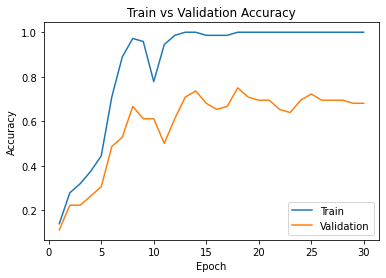

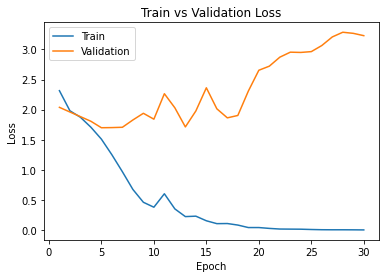

In [ ]:
### Sanity Check

batch_size = 36
overfit_train_loader, overfit_val_loader, overfit_test_loader, classes = get_data_loader (batch_size)

model_0 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_0, overfit_train_loader, overfit_val_loader, batch_size=32, num_epochs=30, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.9622 	 Val acc:0.9417 	 Training loss:0.4054 	 Val loss:0.2025
Epoch:  2 	 Training acc: 0.9775 	 Val acc:0.9602 	 Training loss:0.0949 	 Val loss:0.1508
Epoch:  3 	 Training acc: 0.9882 	 Val acc:0.9707 	 Training loss:0.0695 	 Val loss:0.1093
Epoch:  4 	 Training acc: 0.9908 	 Val acc:0.9733 	 Training loss:0.0514 	 Val loss:0.1124
Epoch:  5 	 Training acc: 0.9762 	 Val acc:0.9552 	 Training loss:0.0466 	 Val loss:0.2502
Epoch:  6 	 Training acc: 0.9848 	 Val acc:0.9637 	 Training loss:0.0400 	 Val loss:0.2186
Epoch:  7 	 Training acc: 0.9824 	 Val acc:0.9681 	 Training loss:0.0517 	 Val loss:0.1668
Epoch:  8 	 Training acc: 0.9979 	 Val acc:0.9833 	 Training loss:0.0312 	 Val loss:0.0713
Epoch:  9 	 Training acc: 0.9955 	 Val acc:0.9789 	 Training loss:0.0313 	 Val loss:0.1020
Epoch:  10 	 Training acc: 0.997 	 Val acc:0.9800 	 Training loss:0.0294 	 Val loss:0.1582
Epoch:  11 	 Training acc: 0.9976 	 Val acc:0.

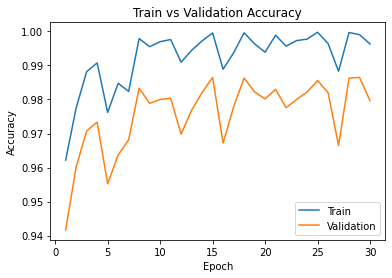

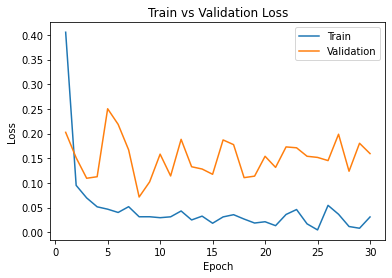

In [ ]:
model_1 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_1, train_loader, val_loader, batch_size=32, num_epochs=30, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...
U S I N G   C U D A 
epoch:  0 training acc:  0.1111111111111111 val acc:  0.1111111111111111 training loss:  2.201994569168478 val loss:  2.1979341788554754
epoch:  1 training acc:  0.1111111111111111 val acc:  0.1111111111111111 training loss:  2.198701372808208 val loss:  2.1979337639696017
epoch:  2 training acc:  0.1111111111111111 val acc:  0.1111111111111111 training loss:  2.198704071254698 val loss:  2.197933889749482
epoch:  3 training acc:  0.1111111111111111 val acc:  0.1111111111111111 training loss:  2.198705068094476 val loss:  2.197933518041776
epoch:  4 training acc:  0.1111111111111111 val acc:  0.1111111111111111 training loss:  2.1987055372667395 val loss:  2.197934150695801
epoch:  5 training acc:  0.1111111111111111 val acc:  0.1111111111111111 training loss:  2.198705747446231 val loss:  2.1979337301779918
epoch:  6 training acc:  0.1111111111111111 val acc:  0.1111111111111111 training loss:  2.19870586403332 val loss:  2.197934049320972
epoc

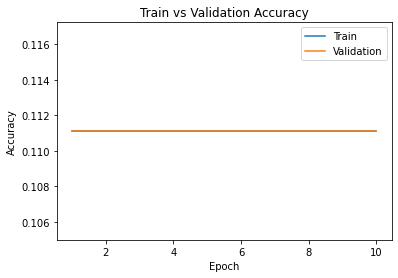

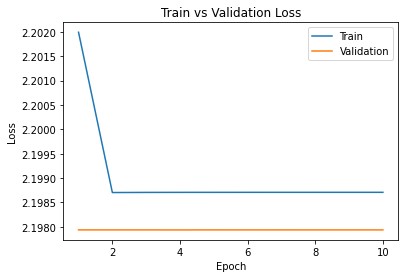

In [ ]:
model_2 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_2, train_loader, val_loader, batch_size=32, num_epochs=10, learning_rate = 0.01)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  0 	 Training acc: 0.947 	 Val acc:0.9333 	 Training loss:0.4890 	 Val loss:0.2444
Epoch:  1 	 Training acc: 0.9726 	 Val acc:0.9652 	 Training loss:0.1250 	 Val loss:0.1255
Epoch:  2 	 Training acc: 0.9861 	 Val acc:0.9731 	 Training loss:0.0730 	 Val loss:0.1569
Epoch:  3 	 Training acc: 0.9864 	 Val acc:0.9775 	 Training loss:0.0719 	 Val loss:0.0964
Epoch:  4 	 Training acc: 0.9953 	 Val acc:0.9869 	 Training loss:0.0497 	 Val loss:0.0642
Epoch:  5 	 Training acc: 0.991 	 Val acc:0.9815 	 Training loss:0.0428 	 Val loss:0.0920
Epoch:  6 	 Training acc: 0.9865 	 Val acc:0.9733 	 Training loss:0.0407 	 Val loss:0.1204
Epoch:  7 	 Training acc: 0.9943 	 Val acc:0.9815 	 Training loss:0.0377 	 Val loss:0.1061
Epoch:  8 	 Training acc: 0.9849 	 Val acc:0.9728 	 Training loss:0.0294 	 Val loss:0.1974
Epoch:  9 	 Training acc: 0.9953 	 Val acc:0.9832 	 Training loss:0.0333 	 Val loss:0.0941


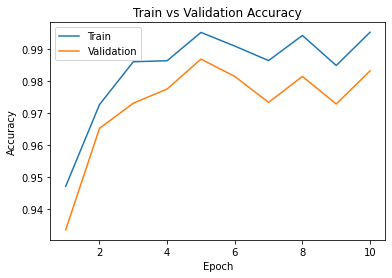

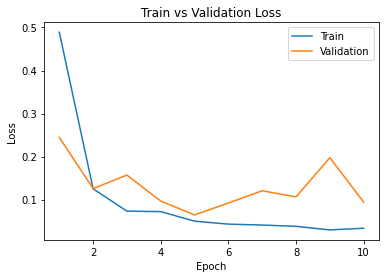

In [ ]:
model_3 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_3, train_loader, val_loader, batch_size=32, num_epochs=10, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  0 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1992 	 Val loss:2.1975
Epoch:  1 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1981 	 Val loss:2.1975
Epoch:  2 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1981 	 Val loss:2.1975
Epoch:  3 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1981 	 Val loss:2.1975
Epoch:  4 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1981 	 Val loss:2.1975
Epoch:  5 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1981 	 Val loss:2.1975
Epoch:  6 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1981 	 Val loss:2.1975
Epoch:  7 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1981 	 Val loss:2.1975
Epoch:  8 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1981 	 Val loss:2.1975
Epoch:  9 	 Training acc: 0.1111 	 Val acc:0.1111 	 Training loss:2.1981 	 Val loss:2.1975


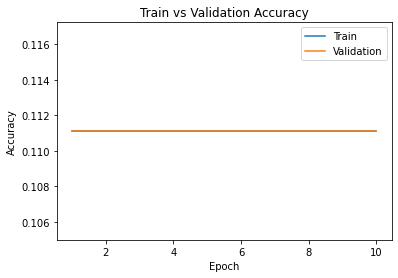

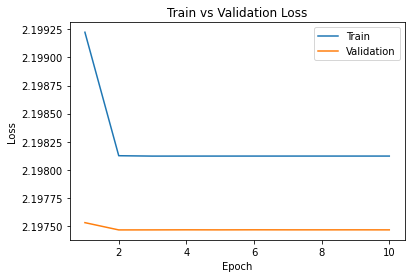

In [ ]:
model_4 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_4, train_loader, val_loader, batch_size=32, num_epochs=10, learning_rate = 0.005)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.8985 	 Val acc:0.8847 	 Training loss:0.9972 	 Val loss:0.4481
Epoch:  2 	 Training acc: 0.9329 	 Val acc:0.9240 	 Training loss:0.3156 	 Val loss:0.2939
Epoch:  3 	 Training acc: 0.957 	 Val acc:0.9420 	 Training loss:0.2093 	 Val loss:0.2230
Epoch:  4 	 Training acc: 0.9693 	 Val acc:0.9548 	 Training loss:0.1553 	 Val loss:0.1813
Epoch:  5 	 Training acc: 0.9765 	 Val acc:0.9583 	 Training loss:0.1167 	 Val loss:0.1639
Epoch:  6 	 Training acc: 0.9792 	 Val acc:0.9585 	 Training loss:0.0903 	 Val loss:0.1546
Epoch:  7 	 Training acc: 0.9839 	 Val acc:0.9654 	 Training loss:0.0679 	 Val loss:0.1376
Epoch:  8 	 Training acc: 0.9851 	 Val acc:0.9627 	 Training loss:0.0527 	 Val loss:0.1529
Epoch:  9 	 Training acc: 0.9832 	 Val acc:0.9704 	 Training loss:0.0475 	 Val loss:0.1230
Epoch:  10 	 Training acc: 0.9947 	 Val acc:0.9770 	 Training loss:0.0337 	 Val loss:0.1103
Epoch:  11 	 Training acc: 0.9878 	 Val acc:0.

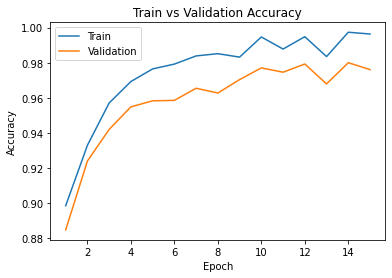

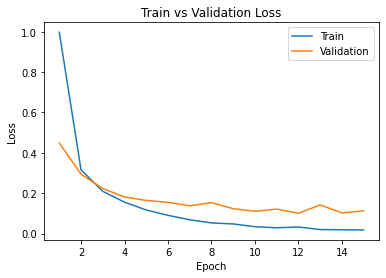

In [ ]:
model_5 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_5, train_loader, val_loader, batch_size=32, num_epochs=15, learning_rate = 0.0001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.428 	 Val acc:0.4210 	 Training loss:2.0204 	 Val loss:1.8195
Epoch:  2 	 Training acc: 0.6194 	 Val acc:0.6264 	 Training loss:1.6027 	 Val loss:1.3874
Epoch:  3 	 Training acc: 0.732 	 Val acc:0.7358 	 Training loss:1.2195 	 Val loss:1.0920
Epoch:  4 	 Training acc: 0.7969 	 Val acc:0.7916 	 Training loss:0.9724 	 Val loss:0.8946
Epoch:  5 	 Training acc: 0.842 	 Val acc:0.8390 	 Training loss:0.7923 	 Val loss:0.7324
Epoch:  6 	 Training acc: 0.8715 	 Val acc:0.8627 	 Training loss:0.6537 	 Val loss:0.6217
Epoch:  7 	 Training acc: 0.8907 	 Val acc:0.8807 	 Training loss:0.5571 	 Val loss:0.5439
Epoch:  8 	 Training acc: 0.9064 	 Val acc:0.8916 	 Training loss:0.4846 	 Val loss:0.4847
Epoch:  9 	 Training acc: 0.9168 	 Val acc:0.9010 	 Training loss:0.4293 	 Val loss:0.4416
Epoch:  10 	 Training acc: 0.9237 	 Val acc:0.9054 	 Training loss:0.3866 	 Val loss:0.4075
Epoch:  11 	 Training acc: 0.9287 	 Val acc:0.90

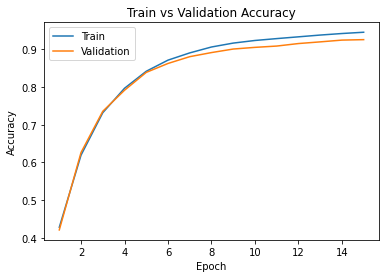

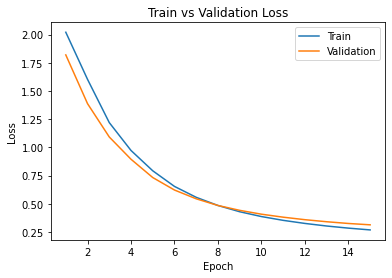

In [ ]:
model_6 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_6, train_loader, val_loader, batch_size=32, num_epochs=15, learning_rate = 0.00001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.9681 	 Val acc:0.9528 	 Training loss:0.5516 	 Val loss:0.1858
Epoch:  2 	 Training acc: 0.9798 	 Val acc:0.9686 	 Training loss:0.1241 	 Val loss:0.1394
Epoch:  3 	 Training acc: 0.9897 	 Val acc:0.9760 	 Training loss:0.0789 	 Val loss:0.1107
Epoch:  4 	 Training acc: 0.9939 	 Val acc:0.9835 	 Training loss:0.0570 	 Val loss:0.1137
Epoch:  5 	 Training acc: 0.9904 	 Val acc:0.9778 	 Training loss:0.0587 	 Val loss:0.1099
Epoch:  6 	 Training acc: 0.9893 	 Val acc:0.9765 	 Training loss:0.0448 	 Val loss:0.1676
Epoch:  7 	 Training acc: 0.9572 	 Val acc:0.9514 	 Training loss:0.0359 	 Val loss:0.4780
Epoch:  8 	 Training acc: 0.9976 	 Val acc:0.9864 	 Training loss:0.0356 	 Val loss:0.1032
Epoch:  9 	 Training acc: 0.9908 	 Val acc:0.9830 	 Training loss:0.0348 	 Val loss:0.0970
Epoch:  10 	 Training acc: 0.9901 	 Val acc:0.9812 	 Training loss:0.0289 	 Val loss:0.0845
Epoch:  11 	 Training acc: 0.9944 	 Val acc:0

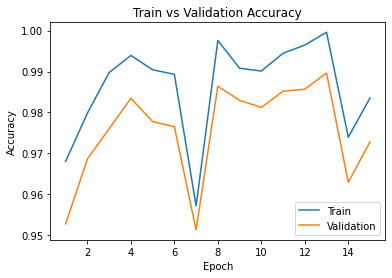

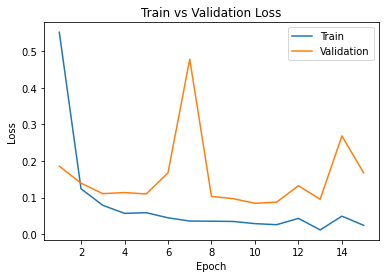

In [ ]:
model_7 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_7, train_loader, val_loader, batch_size=32, num_epochs=15, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

72
72
Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.2222 	 Val acc:0.2222 	 Training loss:2.2498 	 Val loss:2.3234
Epoch:  2 	 Training acc: 0.1111 	 Val acc:0.1250 	 Training loss:2.1852 	 Val loss:2.0688
Epoch:  3 	 Training acc: 0.2222 	 Val acc:0.2222 	 Training loss:1.9656 	 Val loss:1.9673
Epoch:  4 	 Training acc: 0.2222 	 Val acc:0.2222 	 Training loss:1.8684 	 Val loss:1.8985
Epoch:  5 	 Training acc: 0.3472 	 Val acc:0.2361 	 Training loss:1.7826 	 Val loss:1.8424
Epoch:  6 	 Training acc: 0.4028 	 Val acc:0.2639 	 Training loss:1.6923 	 Val loss:1.7778
Epoch:  7 	 Training acc: 0.5139 	 Val acc:0.4722 	 Training loss:1.5993 	 Val loss:1.6969
Epoch:  8 	 Training acc: 0.6111 	 Val acc:0.5139 	 Training loss:1.4814 	 Val loss:1.6098
Epoch:  9 	 Training acc: 0.6528 	 Val acc:0.5694 	 Training loss:1.3425 	 Val loss:1.5136
Epoch:  10 	 Training acc: 0.8611 	 Val acc:0.6528 	 Training loss:1.1868 	 Val loss:1.3685
Epoch:  11 	 Training acc: 0.9167 	 Val

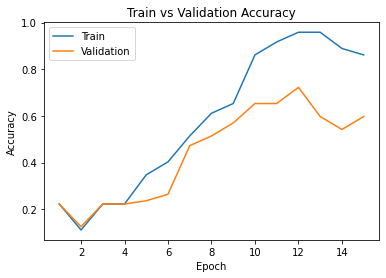

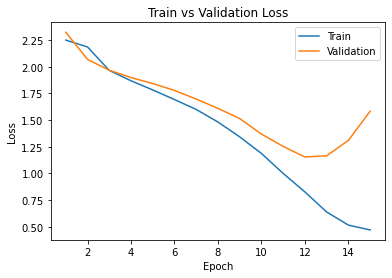

In [ ]:
batch_size = 512
train_loader1, val_loader1, test_loader1, classes = get_data_loader (batch_size)

model_8 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_8, train_loader1, val_loader1, batch_size=512, num_epochs=15, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

72
72
Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.2222 	 Val acc:0.2222 	 Training loss:2.2498 	 Val loss:2.3234
Epoch:  2 	 Training acc: 0.1111 	 Val acc:0.1250 	 Training loss:2.1852 	 Val loss:2.0688
Epoch:  3 	 Training acc: 0.2222 	 Val acc:0.2222 	 Training loss:1.9656 	 Val loss:1.9673
Epoch:  4 	 Training acc: 0.2222 	 Val acc:0.2222 	 Training loss:1.8684 	 Val loss:1.8985
Epoch:  5 	 Training acc: 0.3472 	 Val acc:0.2361 	 Training loss:1.7826 	 Val loss:1.8424
Epoch:  6 	 Training acc: 0.4028 	 Val acc:0.2639 	 Training loss:1.6923 	 Val loss:1.7778
Epoch:  7 	 Training acc: 0.5139 	 Val acc:0.4722 	 Training loss:1.5993 	 Val loss:1.6969
Epoch:  8 	 Training acc: 0.6111 	 Val acc:0.5139 	 Training loss:1.4814 	 Val loss:1.6098
Epoch:  9 	 Training acc: 0.6528 	 Val acc:0.5694 	 Training loss:1.3425 	 Val loss:1.5136
Epoch:  10 	 Training acc: 0.8611 	 Val acc:0.6528 	 Training loss:1.1868 	 Val loss:1.3685
Epoch:  11 	 Training acc: 0.9167 	 Val

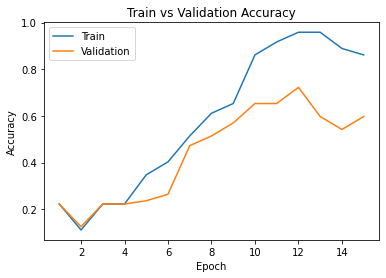

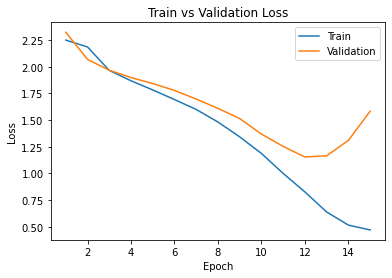

In [ ]:
batch_size = 256
train_loader2, val_loader2, test_loader2, classes = get_data_loader (batch_size)

model_9 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_9, train_loader2, val_loader2, batch_size=256, num_epochs=15, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

72
72
Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.2222 	 Val acc:0.2222 	 Training loss:2.2498 	 Val loss:2.3234
Epoch:  2 	 Training acc: 0.1111 	 Val acc:0.1250 	 Training loss:2.1852 	 Val loss:2.0688
Epoch:  3 	 Training acc: 0.2222 	 Val acc:0.2222 	 Training loss:1.9656 	 Val loss:1.9673
Epoch:  4 	 Training acc: 0.2222 	 Val acc:0.2222 	 Training loss:1.8684 	 Val loss:1.8985
Epoch:  5 	 Training acc: 0.3472 	 Val acc:0.2361 	 Training loss:1.7826 	 Val loss:1.8424
Epoch:  6 	 Training acc: 0.4028 	 Val acc:0.2639 	 Training loss:1.6923 	 Val loss:1.7778
Epoch:  7 	 Training acc: 0.5139 	 Val acc:0.4722 	 Training loss:1.5993 	 Val loss:1.6969
Epoch:  8 	 Training acc: 0.6111 	 Val acc:0.5139 	 Training loss:1.4814 	 Val loss:1.6098
Epoch:  9 	 Training acc: 0.6528 	 Val acc:0.5694 	 Training loss:1.3425 	 Val loss:1.5136
Epoch:  10 	 Training acc: 0.8611 	 Val acc:0.6528 	 Training loss:1.1868 	 Val loss:1.3685
Epoch:  11 	 Training acc: 0.9167 	 Val

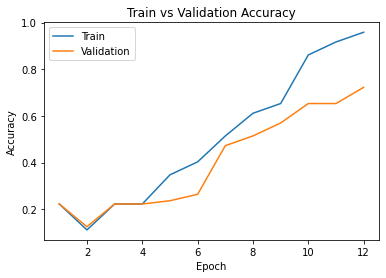

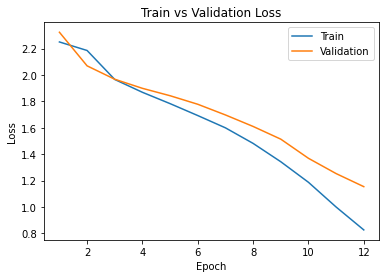

In [ ]:
batch_size = 256
train_loader2, val_loader2, test_loader2, classes = get_data_loader (batch_size)

model_10 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_10, train_loader2, val_loader2, batch_size=256, num_epochs=12, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

72
72
Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.1528 	 Val acc:0.2361 	 Training loss:2.4302 	 Val loss:2.1592
Epoch:  2 	 Training acc: 0.25 	 Val acc:0.1389 	 Training loss:2.0850 	 Val loss:2.0458
Epoch:  3 	 Training acc: 0.3333 	 Val acc:0.3194 	 Training loss:1.9519 	 Val loss:1.9193
Epoch:  4 	 Training acc: 0.3333 	 Val acc:0.3056 	 Training loss:1.8313 	 Val loss:1.8215
Epoch:  5 	 Training acc: 0.3889 	 Val acc:0.3333 	 Training loss:1.7380 	 Val loss:1.7353
Epoch:  6 	 Training acc: 0.4306 	 Val acc:0.3333 	 Training loss:1.6284 	 Val loss:1.6691
Epoch:  7 	 Training acc: 0.5278 	 Val acc:0.3750 	 Training loss:1.5164 	 Val loss:1.5983
Epoch:  8 	 Training acc: 0.6667 	 Val acc:0.5139 	 Training loss:1.3988 	 Val loss:1.4934
Epoch:  9 	 Training acc: 0.8056 	 Val acc:0.6111 	 Training loss:1.2477 	 Val loss:1.3932
Epoch:  10 	 Training acc: 0.8194 	 Val acc:0.5833 	 Training loss:1.0775 	 Val loss:1.3293
Epoch:  11 	 Training acc: 0.8472 	 Val a

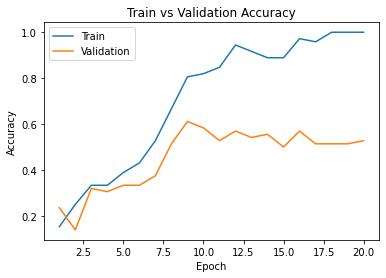

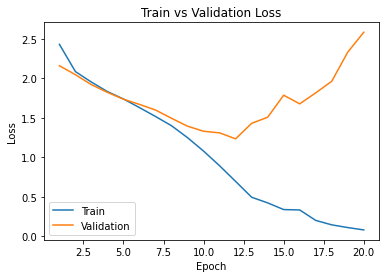

In [ ]:
batch_size = 128
train_loader3, val_loader3, test_loader3, classes = get_data_loader (batch_size)

model_11 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_11, train_loader3, val_loader3, batch_size=128, num_epochs=20, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

72
72
Training Started...

U S I N G   C U D A 


Epoch:  1 	 Training acc: 0.2639 	 Val acc:0.2500 	 Training loss:2.1756 	 Val loss:2.0511
Epoch:  2 	 Training acc: 0.2361 	 Val acc:0.2361 	 Training loss:1.8193 	 Val loss:2.0314
Epoch:  3 	 Training acc: 0.4028 	 Val acc:0.3611 	 Training loss:1.5425 	 Val loss:1.9362
Epoch:  4 	 Training acc: 0.5972 	 Val acc:0.5139 	 Training loss:1.2452 	 Val loss:1.5973
Epoch:  5 	 Training acc: 0.7639 	 Val acc:0.6250 	 Training loss:0.9002 	 Val loss:1.3232
Epoch:  6 	 Training acc: 0.9028 	 Val acc:0.6111 	 Training loss:0.5829 	 Val loss:1.1492
Epoch:  7 	 Training acc: 0.875 	 Val acc:0.6806 	 Training loss:0.3703 	 Val loss:1.3750
Epoch:  8 	 Training acc: 0.7778 	 Val acc:0.5556 	 Training loss:0.2839 	 Val loss:2.2159
Epoch:  9 	 Training acc: 0.9167 	 Val acc:0.6111 	 Training loss:0.4969 	 Val loss:1.1959
Epoch:  10 	 Training acc: 0.9028 	 Val acc:0.5833 	 Training loss:0.1915 	 Val loss:2.4396
Epoch:  11 	 Training acc: 0.875 	 Val a

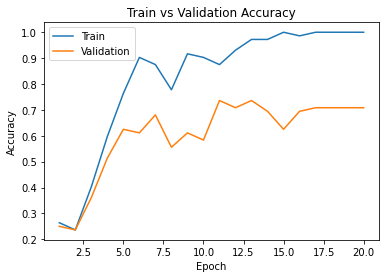

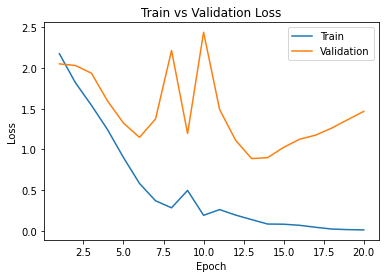

In [ ]:
batch_size = 64
train_loader4, val_loader4, test_loader4, classes = get_data_loader (batch_size)

model_12 = SignClassifier()
use_cuda = False
train_acc, val_acc, train_loss, val_loss = train(model_12, train_loader4, val_loader4, batch_size=128, num_epochs=20, learning_rate = 0.001)
plot_training_curve(train_acc, val_acc, train_loss, val_loss)

torch.Size([1, 3, 32, 32])
Speed limit (81km/h)


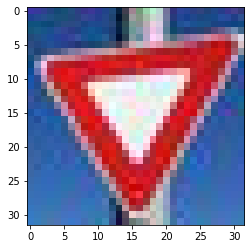

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


img = Image.open("yield.jpg")
image = ToTensor()(img).unsqueeze(0)
print(image.size())

out = model_1(image)
idx = torch.argmax(out)

classes = ['Speed limit (20km/h)',
        'Speed limit (30km/h)',
        'Speed limit (50km/h)',
        'Speed limit (60km/h)',
        'Speed limit (70km/h)',
        'Speed limit (81km/h)',
        'End of speed limit (80km/h)',
        'Speed limit (100km/h)',
        'Speed limit (120km/h)',
        'Yield',
        'Stop',
        'End of all speed and passing limits']


print(classes[idx])

image = ToTensor()(img).squeeze(0)
plt.imshow(image.permute(1,2,0))

tensor([11.,  0.,  3.,  8.,  3., 11.,  0.,  0.,  2.,  7.,  2., 11.,  3.,  2.,
        11.,  5.,  6.,  8.,  2.,  2.,  5., 10.,  0.,  3.,  3.,  9.,  1.,  0.,
         4., 11., 11.,  9.])
Stop


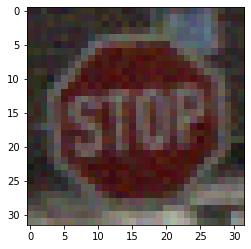

In [ ]:
train_data = iter(train_loader)
imgs, labels = train_data.next()

print(labels)

#for img in imgs:
plt.imshow(np.transpose(imgs[21].numpy().astype(int), (1, 2, 0)))
out = model_1(imgs[21].unsqueeze(0))
idx = torch.argmax(out)
print(classes[idx])